In [25]:
import sys,os
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import plotting
import pandas as pd
from root_pandas import read_root, to_root
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.externals import joblib
from sklearn.utils.class_weight import compute_sample_weight
from scipy.stats import ks_2samp

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

In [26]:
#Bc -> tau nu signal
path = f"{loc.OUT}/ROOT"
df_sig = read_root(f"{path}/Bc2TauNu.root","events")

In [27]:
#Z -> bb inclusive
df_bkg = {}
for q in ["uds","cc","bb"]:
    df_bkg[q] = read_root(f"{path}/inclusive_Z{q}.root","events")

In [28]:
#Variables to use in the MVA
training_vars = ["EVT_thrutshemis_e_min",
                 "EVT_thrutshemis_e_max",
                 "echarged_min",
                 "echarged_max",
                 "eneutral_min",
                 "eneutral_max",
                 "ncharged_min",
                 "ncharged_max",
                 "nneutral_min",
                 "nneutral_max"
                ]

In [29]:
#Keep only these variables
df_sig = df_sig[training_vars]
for q in ["uds","cc","bb"]:
    df_bkg[q] = df_bkg[q][training_vars]

In [30]:
#Make a combined background sample according to BFs
n_tot_bkg = 1e6
BF = {}
BF["bb"] = 0.1512
BF["cc"] = 0.1203
BF["uds"] = 0.6991 - BF["bb"] - BF["cc"]
BF_tot = BF["uds"] + BF["cc"] + BF["bb"]
for q in ["uds","cc","bb"]:
    BF[q] = BF[q] / BF_tot
    df_bkg[q] = df_bkg[q].sample(n=int(n_tot_bkg*BF[q]),random_state=10)

#Add backgrounds together
df_bkg_tot = df_bkg["uds"].append(df_bkg["cc"])
df_bkg_tot = df_bkg_tot.append(df_bkg["bb"])
#Shuffle the background so it is an even mixture of the modes
df_bkg_tot = df_bkg_tot.sample(frac=1)

In [31]:
#Signal and background labels
df_sig["label"] = 1
df_bkg_tot["label"] = 0

#Combine the datasets
df_tot = df_sig.append(df_bkg_tot)

In [32]:
#Split into class label (y) and training vars (x)
y = df_tot["label"]
x = df_tot[training_vars]

In [33]:
#Split into samples to be used in the two BDTs, which will be used to make predictions for each other
x_A, x_B, y_A, y_B = train_test_split(x, y, test_size=0.5, random_state=10)

In [34]:
#Sample weights to balance the classes
weights_A = compute_sample_weight(class_weight='balanced', y=y_A)
weights_B = compute_sample_weight(class_weight='balanced', y=y_B)

In [35]:
#BDTs for each sample, which we will apply to the other sample (cross BDT)
config_dict = {"n_estimators": 200,
               "max_depth": 2,
               "learning_rate": 0.4,
               "verbose": 1,
               "loss": "deviance"
              }

bdt_A = GradientBoostingClassifier(n_estimators=config_dict["n_estimators"], 
                                   max_depth=config_dict["max_depth"], 
                                   learning_rate=config_dict["learning_rate"], 
                                   verbose=config_dict["verbose"],
                                   loss=config_dict["loss"]
                                  )

bdt_B = GradientBoostingClassifier(n_estimators=config_dict["n_estimators"], 
                                   max_depth=config_dict["max_depth"], 
                                   learning_rate=config_dict["learning_rate"], 
                                   verbose=config_dict["verbose"],
                                   loss=config_dict["loss"]
                                  )

In [36]:
#Fit the models
bdt_A.fit(x_A, y_A, sample_weight=weights_A)
bdt_B.fit(x_B, y_B, sample_weight=weights_B) 

      Iter       Train Loss   Remaining Time 
         1           0.9564            1.63m
         2           0.7506            1.61m
         3           0.6361            1.59m
         4           0.5593            1.61m
         5           0.5154            1.75m
         6           0.4651            1.83m
         7           0.4410            1.83m
         8           0.4216            1.77m
         9           0.4112            1.74m
        10           0.3973            1.70m
        20           0.3370            1.54m
        30           0.3098            1.44m
        40           0.2898            1.36m
        50           0.2741            1.26m
        60           0.2650            1.19m
        70           0.2549            1.10m
        80           0.2466            1.02m
        90           0.2395           55.91s
       100           0.2336           50.80s
       200           0.1885            0.00s
      Iter       Train Loss   Remaining Time 
        

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.4, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)

In [37]:
#Get the feature importances 
feature_importances_A = pd.DataFrame(bdt_A.feature_importances_,
                                     index = training_vars,
                                     columns=['importance']).sort_values('importance',ascending=False)

print("Feature importances for BDT A")
print(feature_importances_A)

feature_importances_B = pd.DataFrame(bdt_B.feature_importances_,
                                     index = training_vars,
                                     columns=['importance']).sort_values('importance',ascending=False)

print("Feature importances for BDT B")
print(feature_importances_B)

Feature importances for BDT A
                       importance
EVT_thrutshemis_e_min    0.819630
eneutral_min             0.098794
EVT_thrutshemis_e_max    0.048881
echarged_min             0.022552
echarged_max             0.004252
eneutral_max             0.003149
ncharged_min             0.001495
ncharged_max             0.000573
nneutral_min             0.000420
nneutral_max             0.000254
Feature importances for BDT B
                       importance
EVT_thrutshemis_e_min    0.827061
eneutral_min             0.100121
EVT_thrutshemis_e_max    0.039972
echarged_min             0.022031
eneutral_max             0.004822
echarged_max             0.003709
ncharged_min             0.000820
ncharged_max             0.000678
nneutral_max             0.000567
nneutral_min             0.000218


In [38]:
#Assess the performance on the sample not used in the training
y_predicted_B = bdt_A.predict(x_B)
print(classification_report(y_B, 
                            y_predicted_B,
                            target_names=["background", "signal"])
     )
print("Area under ROC curve A: %.4f"%(roc_auc_score(y_B, bdt_A.decision_function(x_B))))

y_predicted_A = bdt_B.predict(x_A)
print(classification_report(y_A, 
                            y_predicted_A,
                            target_names=["background", "signal"])
     )
print("Area under ROC curve A: %.4f"%(roc_auc_score(y_A, bdt_B.decision_function(x_A))))

              precision    recall  f1-score   support

  background       1.00      0.95      0.97    499895
      signal       0.20      0.96      0.33      6423

    accuracy                           0.95    506318
   macro avg       0.60      0.95      0.65    506318
weighted avg       0.99      0.95      0.97    506318

Area under ROC curve A: 0.9908
              precision    recall  f1-score   support

  background       1.00      0.95      0.97    500104
      signal       0.19      0.95      0.32      6214

    accuracy                           0.95    506318
   macro avg       0.59      0.95      0.65    506318
weighted avg       0.99      0.95      0.97    506318

Area under ROC curve A: 0.9910


In [39]:
#Create ROC curves
decisions_B = bdt_A.decision_function(x_B)
decisions_A = bdt_B.decision_function(x_A)

# Compute ROC curves and area under the curve
fpr_A, tpr_A, thresholds_A = roc_curve(y_A, decisions_A)
roc_auc_A = auc(fpr_A, tpr_A)

fpr_B, tpr_B, thresholds_B = roc_curve(y_B, decisions_B)
roc_auc_B = auc(fpr_B, tpr_B)

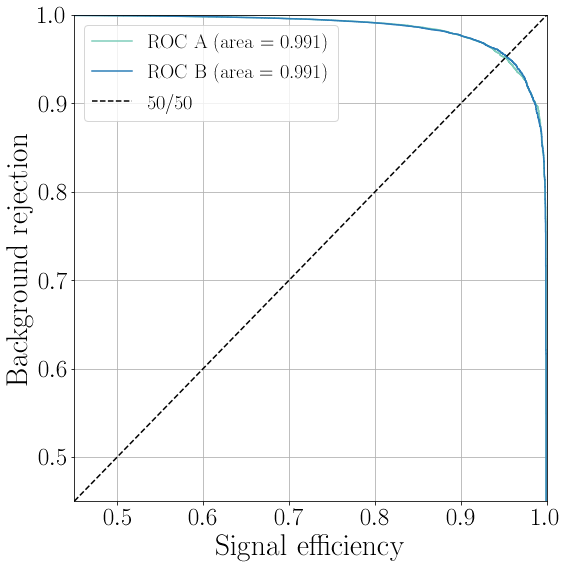

In [40]:
fig, ax = plt.subplots(figsize=(8,8))
plt.plot(tpr_A, 1-fpr_A, lw=1.5, color="#7fcdbb", label='ROC A (area = %0.3f)'%(roc_auc_A))
plt.plot(tpr_B, 1-fpr_B, lw=1.5, color="#2c7fb8", label='ROC B (area = %0.3f)'%(roc_auc_B))

plt.plot([0.45, 1.], [0.45, 1.], linestyle="--", color="k", label='50/50')
plt.xlim(0.45,1.)
plt.ylim(0.45,1.)
plt.ylabel('Background rejection',fontsize=30)
plt.xlabel('Signal efficiency',fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.legend(loc="upper left",fontsize=20)
plt.grid()
plt.tight_layout()
plt.show()
fig.savefig(f"{loc.PLOTS}/Bc2TauNu_vs_inclusive_Zbb_ROC.pdf")

In [41]:
#Get BDT scores
sig_A, sig_B = train_test_split(df_sig, test_size=0.5, random_state=10)
bkg_A, bkg_B = train_test_split(df_bkg_tot, test_size=0.5, random_state=10)
sig_A = sig_A[training_vars]
sig_B = sig_B[training_vars]
bkg_A = bkg_A[training_vars]
bkg_B = bkg_B[training_vars]
sig_A["BDT"] = bdt_B.decision_function(sig_A).tolist()
sig_B["BDT"] = bdt_A.decision_function(sig_B).tolist()
bkg_A["BDT"] = bdt_B.decision_function(bkg_A).tolist()
bkg_B["BDT"] = bdt_A.decision_function(bkg_B).tolist()

In [42]:
#Combine the samples and plot signal and background BDTs
sig_tot = sig_A.append(sig_B)
bkg_tot = bkg_A.append(bkg_B)

In [43]:
#Cut at maximum bkg value of the BDT and count the signal and background effs

BDT_cut = bkg_tot["BDT"].max()
n_sig_BDT = float(len(sig_tot.query(f"BDT > {BDT_cut}")))
n_sig_tot = len(sig_tot)
eff_sig = n_sig_BDT / n_sig_tot
print(f"Signal efficieny for BDT > {BDT_cut}: {eff_sig}")

n_bkg_BDT = float(len(bkg_tot.query(f"BDT > {BDT_cut}")))
n_bkg_tot = len(bkg_tot)
eff_bkg = n_bkg_BDT / n_bkg_tot
print(f"Background efficieny for BDT > {BDT_cut}: {eff_bkg}")

Signal efficieny for BDT > 8.348731941190866: 0.058004273166099546
Background efficieny for BDT > 8.348731941190866: 0.0


In [44]:
#KS tests for signal and background
ks_sig = ks_2samp(sig_A["BDT"],sig_B["BDT"])

ks_bkg = ks_2samp(bkg_A["BDT"],bkg_B["BDT"])

print(f"KS score for signal A vs. B: {ks_sig[0]}")
print(f"KS score for background A vs. B: {ks_bkg[0]}")

KS score for signal A vs. B: 0.04475172756898065
KS score for background A vs. B: 0.062305571635143275


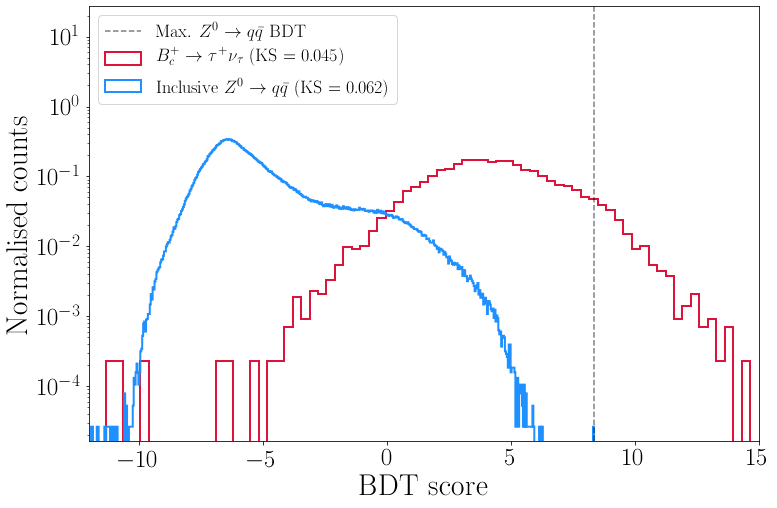

In [45]:
fig, ax = plt.subplots(figsize=(12,8))
xmin = -12
xmax = 15
bins_bkg = int(np.sqrt(len(bkg_A)))
bins_sig = int(np.sqrt(len(sig_A)))
plt.hist(sig_tot["BDT"],bins=bins_sig,range=(xmin,xmax),density=True,color="crimson",histtype='step',linewidth=2,label="$B_c^+ \\to \\tau^+ \\nu_\\tau$ (KS = %.3f)" % ks_sig[0])
#plt.hist(sig_B["BDT"],bins=bins_sig,range=(xmin,xmax),density=True,color="crimson",histtype='stepfilled',alpha=0.5,linewidth=2,label="$B_c^+ \\to \\tau^+ \\nu_\\tau$ (BDT B)")
plt.hist(bkg_tot["BDT"],bins=bins_bkg,range=(xmin,xmax),density=True,color="dodgerblue",histtype='step',linewidth=2,label="Inclusive $Z^0 \\to q\\bar{q}$ (KS = %.3f)" % ks_bkg[0])
#plt.hist(bkg_B["BDT"],bins=bins_bkg,range=(xmin,xmax),density=True,color="dodgerblue",histtype='stepfilled',alpha=0.5,linewidth=2,label="Inclusive $Z^0 \\to q\\bar{q}$ (BDT B)")
plt.axvline(BDT_cut,linestyle='--',color="k",alpha=0.5,label="Max. $Z^0 \\to q \\bar{q}$ BDT")
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlim(xmin,xmax)
plt.xlabel("BDT score",fontsize=30)
plt.ylabel("Normalised counts",fontsize=30)
plt.yscale('log')
ymin,ymax = plt.ylim()
plt.ylim(ymin,50*ymax)
plt.legend(fontsize=18, loc="upper left")
plt.show()
fig.savefig(f"{loc.PLOTS}/Bc2TauNu_vs_inclusive_Zqq_BDT.pdf")

In [46]:
#Get BDT scores for the background components
bkg_A_sub = {}
bkg_B_sub = {}
bkg_tot_sub = {}
for q in ["uds","cc","bb"]:
    bkg_A_sub[q], bkg_B_sub[q] = train_test_split(df_bkg[q], test_size=0.5, random_state=10)
    bkg_A_sub[q] = bkg_A_sub[q][training_vars]
    bkg_B_sub[q] = bkg_B_sub[q][training_vars]
    bkg_A_sub[q]["BDT"] = bdt_B.decision_function(bkg_A_sub[q]).tolist()
    bkg_B_sub[q]["BDT"] = bdt_A.decision_function(bkg_B_sub[q]).tolist()
    bkg_tot_sub[q] = bkg_A_sub[q].append(bkg_B_sub[q])

In [47]:
mode_config = {"uds": ["q\\bar{q}","#fdae61"],
               "cc": ["c\\bar{c}","#abd9e9"],
               "bb": ["b\\bar{b}","#2c7bb6"]
              }

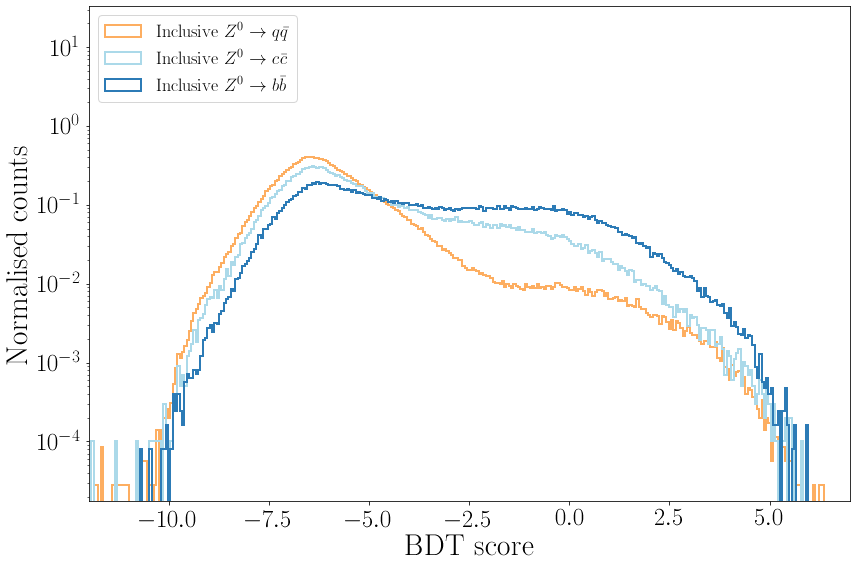

In [48]:
fig, ax = plt.subplots(figsize=(12,8))
xmin = -12
xmax = 7
bins_bkg = int(np.sqrt(len(bkg_A_sub["bb"])))
for q in ["uds","cc","bb"]:
    plt.hist(bkg_tot_sub[q]["BDT"],bins=bins_bkg,range=(xmin,xmax),density=True,color=mode_config[q][1],histtype='step',linewidth=2,label="Inclusive $Z^0 \\to %s$" % (mode_config[q][0]))
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlim(xmin,xmax)
plt.xlabel("BDT score",fontsize=30)
plt.ylabel("Normalised counts",fontsize=30)
plt.yscale('log')
ymin,ymax = plt.ylim()
plt.ylim(ymin,50*ymax)
plt.legend(fontsize=18, loc="upper left")
plt.tight_layout()
plt.show()
fig.savefig(f"{loc.PLOTS}/inclusive_Zqq_BDT.pdf")